<a href="https://colab.research.google.com/github/grmanjar-cmyk/CA_Energy_Market/blob/main/Energy_Markets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Electricity Price Risk Monitor
### Analyzing Forecast vs. Actual Costs in the CAISO Market (Northern California Zone - NP15)

**Author:** Gregory J. Wilson
**Target Role:** Energy Risk Analyst
**Date:** December 2025

## Executive Summary
This project builds a data pipeline to monitor financial risk in California's power grid. It compares the price electricity providers *planned* to pay (Day-Ahead Forecast) versus what they *actually* paid (Real-Time Actuals).

Specifically, this tool queries the **California Independent System Operator (CAISO)** to analyze the "NP15" trading hub, which serves as the pricing reference for Northern California.

For a Community Choice Aggregator (CCA) like **Central Coast Community Energy (3CE)**, monitoring the gap between these two prices (the "DART Spread") is essential for protecting the budget against market volatility.

## Methodology
1.  **Data Extraction:** Programmatic retrieval of pricing data using the **CAISO OASIS API**.
2.  **Data Cleaning:** Parsing raw XML/CSV server responses and filtering for the specific "Locational Marginal Price" (LMP).
3.  **Transformation:** Resampling high-frequency 5-minute data (Real-Time) to match hourly contracts (Day-Ahead) for a direct apples-to-apples comparison.
4.  **Visualization:** Creating a "Buy-Side" Risk Dashboard to highlight hours where market prices spiked unexpectedly.

## Key Libraries
*   `Pandas`: Time-series manipulation and resampling.
*   `Requests`: API endpoint interaction.
*   `Matplotlib/Seaborn`: Financial data visualization.

## Development Note
This project was developed with the assistance of **Google Gemini 3.0** to accelerate the learning curve of energy-specific API protocols and Python syntax. The workflow functioned as an interactive "pair programming" session to ensure code efficiency and clear documentation.

In [1]:
# Block 1: Import Libraries
import pandas as pd
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Make graphs look nice
sns.set_theme(style="whitegrid")

print("Libraries imported successfully. Ready to build the URL generator.")

Libraries imported successfully. Ready to build the URL generator.


# Step 1: Request Data from CAISO OASIS API

**Objective:** Establish a connection to the CAISO server and download the raw Day-Ahead Market (DAM) data for the Northern California Trading Hub (NP15).

**Method:**
We use the `requests` library to hit the CAISO "SingleZip" endpoint.
*   **Node:** `TH_NP15_GEN-APND` (The specific location ID for Northern Path 15).
*   **Date Range:** September 1, 2023 (One day sample for testing).
*   **Format:** The API requires start/end times in specific UTC strings (`YYYYMMDDThh:mm-0000`).

**Success Criteria:**
We expect a `200 OK` status code, indicating the server accepted our request and returned a file.

In [2]:
# Block 2: Request the Data as CSV

# 1. Define the Parameters
base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
node = "TH_NP15_GEN-APND"
start_date = "20230901T07:00-0000"
end_date = "20230902T07:00-0000"

# 2. Construct the URL (Added resultformat=6 for CSV)
url = f"{base_url}?queryname=PRC_LMP&startdatetime={start_date}&enddatetime={end_date}&version=1&market_run_id=DAM&node={node}&resultformat=6"

print(f"Target URL: {url}")

# 3. Make the Request
print("Requesting CSV data from CAISO...")
response = requests.get(url)

if response.status_code == 200:
    print("✅ Success! The server responded with data.")
else:
    print(f"❌ Error. Status Code: {response.status_code}")

Target URL: http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP&startdatetime=20230901T07:00-0000&enddatetime=20230902T07:00-0000&version=1&market_run_id=DAM&node=TH_NP15_GEN-APND&resultformat=6
Requesting CSV data from CAISO...
✅ Success! The server responded with data.


# Step 2: Unzip and Load Data into Pandas

**Objective:** Parse the zipped response from CAISO and load the CSV content into a Pandas DataFrame.

**Method:**
1.  Use `io.BytesIO` to convert the raw binary content of the response into a file-like object in memory.
2.  Use `zipfile.ZipFile` to access the contents of that memory object.
3.  Extract the first file name found in the zip archive.
4.  Use `pd.read_csv` to read that file into a DataFrame named `df`.

**Verification:**
We will print the first 5 rows (`df.head()`) and the list of column names to understand the dataset structure.

In [3]:
# Block 3: Unzip and Create DataFrame

try:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        file_name = z.namelist()[0]
        print(f"Extracting file: {file_name}")

        # Now this should work correctly because the file inside is actually a CSV
        df = pd.read_csv(z.open(file_name))
        print("✅ Data loaded into DataFrame successfully.")

except Exception as e:
    print(f"❌ Error unzipping or reading file: {e}")

# Inspect the Data
print("\n--- First 5 Rows of Data ---")
print(df.head())

print("\n--- Column Names ---")
print(list(df.columns))

Extracting file: 20230901_20230902_PRC_LMP_DAM_20251205_12_29_56_v1.csv
✅ Data loaded into DataFrame successfully.

--- First 5 Rows of Data ---
       INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT      OPR_DT  OPR_HR  \
0  2023-09-02T02:00:00-00:00  2023-09-02T03:00:00-00:00  2023-09-01      20   
1  2023-09-01T12:00:00-00:00  2023-09-01T13:00:00-00:00  2023-09-01       6   
2  2023-09-01T20:00:00-00:00  2023-09-01T21:00:00-00:00  2023-09-01      14   
3  2023-09-02T00:00:00-00:00  2023-09-02T01:00:00-00:00  2023-09-01      18   
4  2023-09-02T01:00:00-00:00  2023-09-02T02:00:00-00:00  2023-09-01      19   

   OPR_INTERVAL       NODE_ID_XML           NODE_ID              NODE  \
0             0  TH_NP15_GEN-APND  TH_NP15_GEN-APND  TH_NP15_GEN-APND   
1             0  TH_NP15_GEN-APND  TH_NP15_GEN-APND  TH_NP15_GEN-APND   
2             0  TH_NP15_GEN-APND  TH_NP15_GEN-APND  TH_NP15_GEN-APND   
3             0  TH_NP15_GEN-APND  TH_NP15_GEN-APND  TH_NP15_GEN-APND   
4             0

# Step 3: Inspect Data Structure and Content

**Objective:** Verify column data types and identify necessary filtering and renaming steps.

**Analysis:**
1.  **Data Types:** We check `df.info()` to see if timestamps are strings or datetime objects.
2.  **Price Components:** We check `df['XML_DATA_ITEM'].value_counts()` to see if the dataset includes breakdown components (Energy, Congestion, Losses) or just the total LMP.
3.  **Renaming:** We confirm that the column `MW` holds the price data, which requires renaming to avoid ambiguity.

In [4]:
# Block 4: Inspect Data Content

# 1. Check Data Types (Dtypes)
print("--- Data Types ---")
print(df.dtypes)

# 2. Check for Multiple Price Components
# We expect to see 'LMP_PRC', but we might also see 'LMP_ENE_PRC', 'LMP_CONG_PRC', etc.
print("\n--- Unique Data Items (Price Components) ---")
print(df['XML_DATA_ITEM'].value_counts())

# 3. Check for specific columns we want to keep
required_cols = ['INTERVALSTARTTIME_GMT', 'XML_DATA_ITEM', 'MW']
print(f"\nVerifying existence of key columns: {required_cols}")

--- Data Types ---
INTERVALSTARTTIME_GMT     object
INTERVALENDTIME_GMT       object
OPR_DT                    object
OPR_HR                     int64
OPR_INTERVAL               int64
NODE_ID_XML               object
NODE_ID                   object
NODE                      object
MARKET_RUN_ID             object
LMP_TYPE                  object
XML_DATA_ITEM             object
PNODE_RESMRID             object
GRP_TYPE                  object
POS                        int64
MW                       float64
GROUP                      int64
dtype: object

--- Unique Data Items (Price Components) ---
XML_DATA_ITEM
LMP_PRC         24
LMP_CONG_PRC    24
LMP_ENE_PRC     24
LMP_LOSS_PRC    24
LMP_GHG_PRC     24
Name: count, dtype: int64

Verifying existence of key columns: ['INTERVALSTARTTIME_GMT', 'XML_DATA_ITEM', 'MW']


# Step 4: Filter and Clean Data

**Objective:** Isolate the Total Price (`LMP_PRC`) and standardise column names/types.

**Method:**
1.  **Filter:** Select rows where `XML_DATA_ITEM == 'LMP_PRC'`. This gives us only total price, not the components of price, so we can calculate average later.
2.  **Rename:** Change `MW` to `DAM_LMP` for Day-Ahead Market Locational Marginal Price  to avoid confusion (since it represents price, not megawatts).
3.  **Type Conversion:** Convert `INTERVALSTARTTIME_GMT` from String to Datetime objects using `pd.to_datetime`.

**Result:** A clean DataFrame ready for analysis.

In [5]:
# Block 5: Filter and Clean

# 1. Filter: Keep only the Total Price rows
# Syntax: df[ df['Column_Name'] == 'Value_To_Keep' ]
clean_df = df[df['XML_DATA_ITEM'] == 'LMP_PRC'].copy()

# 2. Rename Columns
# We apply the correct industry name 'DAM_LMP' immediately
clean_df = clean_df.rename(columns={
    'MW': 'DAM_LMP',
    'INTERVALSTARTTIME_GMT': 'Timestamp'
})

# 3. Convert Timestamp to Datetime Object
clean_df['Timestamp'] = pd.to_datetime(clean_df['Timestamp'], utc=True)

# 4. Simplify: Keep only the columns we need
final_df = clean_df[['Timestamp', 'DAM_LMP']]

# Verification
print("--- Cleaned Data Head ---")
print(final_df.head())

print("\n--- Data Info ---")
print(final_df.info())

--- Cleaned Data Head ---
                  Timestamp   DAM_LMP
0 2023-09-02 02:00:00+00:00  53.98304
1 2023-09-01 12:00:00+00:00  43.53827
2 2023-09-01 20:00:00+00:00  30.80519
3 2023-09-02 00:00:00+00:00  46.81780
4 2023-09-02 01:00:00+00:00  50.67246

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Timestamp  24 non-null     datetime64[ns, UTC]
 1   DAM_LMP    24 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 576.0 bytes
None


# Step 5: Standardize and Sort

**Objective:** Apply industry-standard naming conventions and ensure chronological order.

**Method:**
1.  **Rename:** Change `DAM_Price` to `DAM_LMP` (Locational Marginal Price).
2.  **Sort:** Order the data by `Timestamp` to ensure correct time-series plotting.
3.  **Reset Index:** Clean up the row numbers after sorting.

In [6]:
# Block 6: Rename and Sort

# 1. Rename to Industry Standard
final_df = final_df.rename(columns={'DAM_Price': 'DAM_LMP'})

# 2. Sort by Time (Crucial for plotting)
final_df = final_df.sort_values(by='Timestamp')

# 3. Reset Index (So the rows go 0, 1, 2, 3...)
final_df = final_df.reset_index(drop=True)

# Verification
print("--- Finalized Day-Ahead Data ---")
print(final_df.head())

--- Finalized Day-Ahead Data ---
                  Timestamp   DAM_LMP
0 2023-09-01 07:00:00+00:00  41.41333
1 2023-09-01 08:00:00+00:00  38.97000
2 2023-09-01 09:00:00+00:00  38.60595
3 2023-09-01 10:00:00+00:00  36.84439
4 2023-09-01 11:00:00+00:00  37.04713


# Step 7: Fetch Real-Time Market (RTM) Data

**Objective:** Retrieve the "Actual" price data to compare against the Day-Ahead "Forecast."

**Method:**
We reuse our request logic but modify specific parameters to access the Real-Time Market (RTM).
1.  **Switch Market:** Change `market_run_id` to `RTM`.
2.  **Update Query:** Change `queryname` to `PRC_INTVL_LMP`.
    *   *Note:* The RTM uses a specific "Interval" report because it settles every 5 minutes, unlike the hourly `PRC_LMP` report used for Day-Ahead.

### Technical Detail: Constructing the API Request

We construct the request URL dynamically using Python f-strings. This allows us to easily swap parameters without rewriting the core logic.

| Parameter | Code Variable | Function |
| :--- | :--- | :--- |
| **Base URL** | `base_url` | The entry point for the CAISO OASIS API. |
| **Query Name** | `PRC_INTVL_LMP` | **Changed:** Specifies we are requesting **Interval** (5-min) Prices. |
| **Time Range** | `start_date`, `end_date` | Filters data to our specific UTC window. |
| **Market ID** | `RTM` | **Changed:** Toggles to the Real-Time Market. |
| **Node** | `node` | Filters for the specific pricing node (`TH_NP15_GEN-APND`). |
| **Format** | `resultformat=6` | Forces the server to return a **CSV** rather than the default XML. |

**Expected Result:** A high-frequency dataset containing approximately 288 rows (12 intervals per hour × 24 hours).

In [7]:
# Block 7: Fetch RTM Data

# 1. Update Parameters for Real-Time 5-Minute Data
market_id = "RTM"
query_name = "PRC_INTVL_LMP" # <--- This is the fix (Interval LMP)

# 2. Construct the URL (Using f-string for readability)
url_rtm = f"{base_url}?queryname={query_name}&startdatetime={start_date}&enddatetime={end_date}&version=1&market_run_id={market_id}&node={node}&resultformat=6"

print(f"Requesting RTM (Actual) Data: {url_rtm}")

# 3. Request
response_rtm = requests.get(url_rtm)

# 4. Process
if response_rtm.status_code == 200:
    try:
        with zipfile.ZipFile(io.BytesIO(response_rtm.content)) as z:
            file_name = z.namelist()[0]
            # Read directly into a new DataFrame called df_rtm
            df_rtm = pd.read_csv(z.open(file_name))
            print("✅ RTM Data Downloaded and Loaded.")

            # 5. Initial Inspection
            print("\n--- RTM Data Head ---")
            print(df_rtm.head())
            print(f"\nRow Count: {len(df_rtm)}")
            # We expect roughly 12 intervals * 24 hours = ~288 rows

    except Exception as e:
        print(f"❌ Error Unzipping: {e}")
        # If it fails, print the raw content to debug
        print(response_rtm.content[:500])
else:
    print(f"❌ Error fetching RTM data. Status: {response_rtm.status_code}")

Requesting RTM (Actual) Data: http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_INTVL_LMP&startdatetime=20230901T07:00-0000&enddatetime=20230902T07:00-0000&version=1&market_run_id=RTM&node=TH_NP15_GEN-APND&resultformat=6
✅ RTM Data Downloaded and Loaded.

--- RTM Data Head ---
       INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT      OPR_DT  OPR_HR  \
0  2023-09-01T07:00:00-00:00  2023-09-01T07:05:00-00:00  2023-09-01       1   
1  2023-09-01T07:05:00-00:00  2023-09-01T07:10:00-00:00  2023-09-01       1   
2  2023-09-01T07:10:00-00:00  2023-09-01T07:15:00-00:00  2023-09-01       1   
3  2023-09-01T07:15:00-00:00  2023-09-01T07:20:00-00:00  2023-09-01       1   
4  2023-09-01T07:20:00-00:00  2023-09-01T07:25:00-00:00  2023-09-01       1   

        NODE_ID_XML           NODE_ID              NODE MARKET_RUN_ID  \
0  TH_NP15_GEN-APND  TH_NP15_GEN-APND  TH_NP15_GEN-APND           RTM   
1  TH_NP15_GEN-APND  TH_NP15_GEN-APND  TH_NP15_GEN-APND           RTM   
2  TH_NP15_GEN-APND  T

# Step 8: Inspect and Clean Real-Time Data

**Observation:**
We received 1152 rows, which is 4x our expected count of 288. This indicates we received all price components (Energy, Congestion, Loss, Total) for each 5-minute interval.

**Objective:**
1.  Verify the components present using `value_counts()`.
2.  Filter to keep only the Total Price (`LMP_PRC`).
3.  Rename `MW` to `RTM_LMP` and convert timestamps.
4.  Sort and reset the index.

In [8]:
# Block 8: Process RTM Data

# 1. Verify Components (The "Why 1152?" Check)
print("--- Component Counts ---")
print(df_rtm['XML_DATA_ITEM'].value_counts())

# 2. Filter: Keep only Total Price
rtm_clean = df_rtm[df_rtm['XML_DATA_ITEM'] == 'LMP_PRC'].copy()

# 3. Rename and Format
rtm_clean = rtm_clean.rename(columns={
    'MW': 'RTM_LMP',
    'INTERVALSTARTTIME_GMT': 'Timestamp'
})

# 4. Convert Timestamp (UTC)
rtm_clean['Timestamp'] = pd.to_datetime(rtm_clean['Timestamp'], utc=True)

# 5. Sort and Simplify
rtm_clean = rtm_clean.sort_values(by='Timestamp').reset_index(drop=True)
final_rtm = rtm_clean[['Timestamp', 'RTM_LMP']]

# Verification
print("\n--- Finalized Real-Time Data ---")
print(final_rtm.head())
print(f"\nFinal Row Count: {len(final_rtm)}")
# We expect exactly 288 rows now

--- Component Counts ---
XML_DATA_ITEM
LMP_CONG_PRC    288
LMP_ENE_PRC     288
LMP_LOSS_PRC    288
LMP_PRC         288
Name: count, dtype: int64

--- Finalized Real-Time Data ---
                  Timestamp   RTM_LMP
0 2023-09-01 07:00:00+00:00  39.35924
1 2023-09-01 07:05:00+00:00  40.78492
2 2023-09-01 07:10:00+00:00  40.82670
3 2023-09-01 07:15:00+00:00  42.28348
4 2023-09-01 07:20:00+00:00  42.07497

Final Row Count: 288


# Step 9: Resample and Merge

**Objective:** Align the datasets to allow for direct comparison and calculate the risk metric.

**Method:**
1.  **Resample:** Convert the 5-minute Real-Time data into **Hourly Averages** using `.resample('1h').mean()`.
2.  **Merge:** Join the Day-Ahead dataframe with the new Hourly Real-Time dataframe on the `Timestamp` column.
3.  **Calculate Spread:** Compute the **DART Spread** (Real-Time Price - Day-Ahead Price).
    *   *Significance:* This metric reveals the "Forecast Error." A large spread indicates high volatility and unexpected grid conditions.

In [9]:
# Block 9: Resample, Merge, and Calculate Risk

# 1. Resample RTM to Hourly Averages
# We set the index to Timestamp so Pandas knows what to average
rtm_hourly = final_rtm.set_index('Timestamp').resample('1h').mean().reset_index()

print(f"Resampled RTM rows: {len(rtm_hourly)} (Should be 24)")

# 2. Merge Datasets
# We use an 'inner' join to ensure we only keep hours that exist in BOTH datasets
combined_df = pd.merge(final_df, rtm_hourly, on='Timestamp', how='inner')

# 3. Calculate the DART Spread (Difference)
# Formula: Actual (RTM) - Forecast (DAM)
combined_df['DART_Spread'] = combined_df['RTM_LMP'] - combined_df['DAM_LMP']

# 4. Final Inspection
print("\n--- Master Dataframe (First 5 Hours) ---")
print(combined_df.head())

# Check for data gaps
print("\n--- Data Integrity Check ---")
print(combined_df.info())

Resampled RTM rows: 24 (Should be 24)

--- Master Dataframe (First 5 Hours) ---
                  Timestamp   DAM_LMP    RTM_LMP  DART_Spread
0 2023-09-01 07:00:00+00:00  41.41333  40.601634    -0.811696
1 2023-09-01 08:00:00+00:00  38.97000  35.302826    -3.667174
2 2023-09-01 09:00:00+00:00  38.60595  34.776888    -3.829062
3 2023-09-01 10:00:00+00:00  36.84439  34.544024    -2.300366
4 2023-09-01 11:00:00+00:00  37.04713  38.518184     1.471054

--- Data Integrity Check ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   Timestamp    24 non-null     datetime64[ns, UTC]
 1   DAM_LMP      24 non-null     float64            
 2   RTM_LMP      24 non-null     float64            
 3   DART_Spread  24 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 900.0 bytes
None


# Step 10: Visualization

**Objective:** Visualise market volatility for the selected day.

**Method:**
We create a two-panel plot using `matplotlib`:
1.  **Top Panel (Price Action):** Compares the Day-Ahead Forecast (Blue) vs. Real-Time Actuals (Orange).
    *   *Goal:* Identify hours where the forecast broke down.
2.  **Bottom Panel (Volatility):** A bar chart of the DART Spread.
    *   *Goal:* Quantify the magnitude of the divergence. Bars crossing zero indicate the direction of the error.

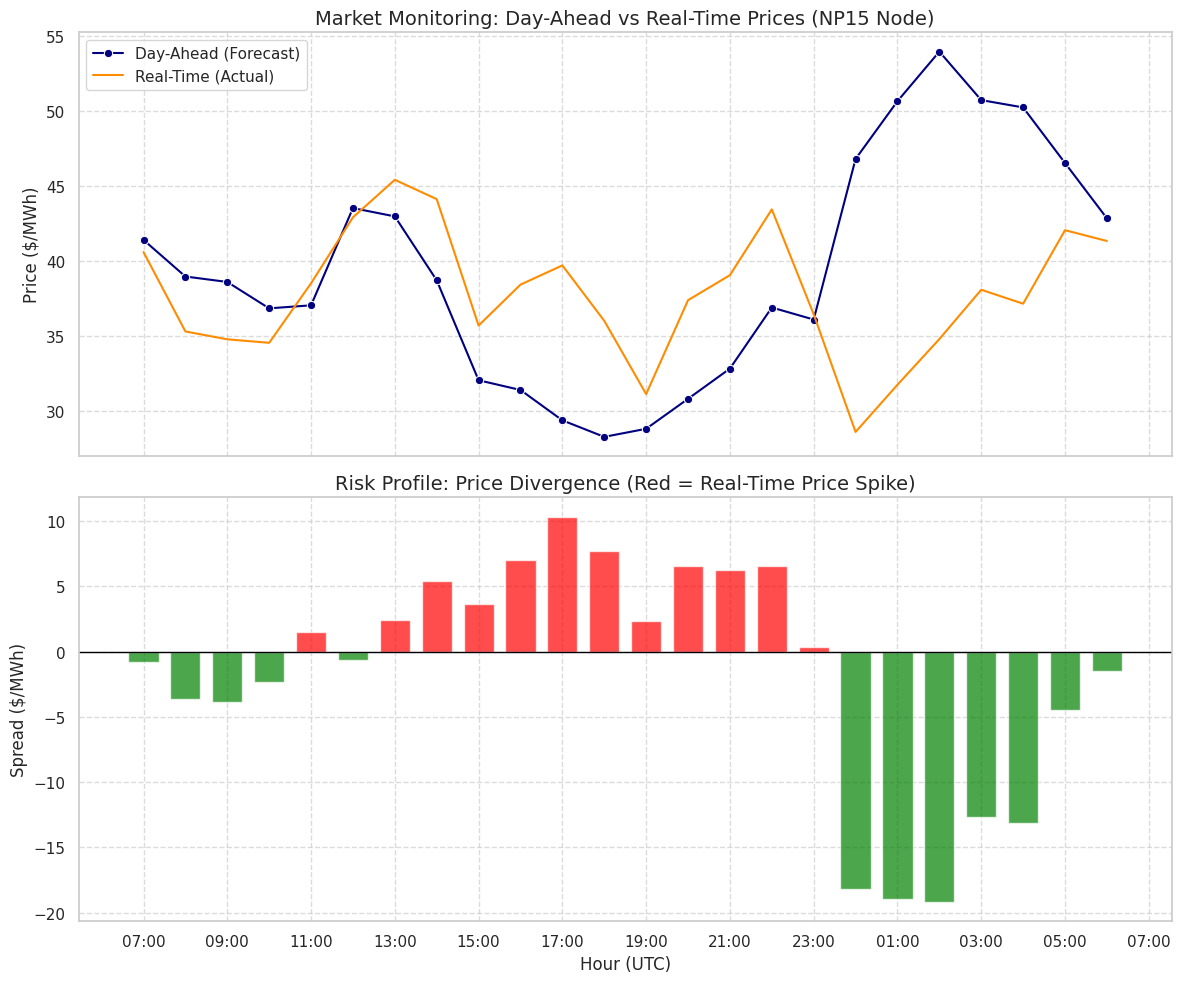

In [11]:
# Block 10: Visualization (Risk Analyst Perspective)

# Setup the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Prices
sns.lineplot(data=combined_df, x='Timestamp', y='DAM_LMP', ax=ax1, label='Day-Ahead (Forecast)', color='navy', marker='o')
sns.lineplot(data=combined_df, x='Timestamp', y='RTM_LMP', ax=ax1, label='Real-Time (Actual)', color='darkorange')
ax1.set_ylabel('Price ($/MWh)')
ax1.set_title('Market Monitoring: Day-Ahead vs Real-Time Prices (NP15 Node)', fontsize=14)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Spread (Risk View)
# LOGIC CHANGE:
# If RTM > DAM (Positive Spread), the price spiked. For a Buyer, this is a COST risk -> RED.
# If RTM < DAM (Negative Spread), the price dropped. For a Buyer, this is neutral/savings -> GREEN.
colors = ['red' if x > 0 else 'green' for x in combined_df['DART_Spread']]

ax2.bar(combined_df['Timestamp'], combined_df['DART_Spread'], width=0.03, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_ylabel('Spread ($/MWh)')
ax2.set_title('Risk Profile: Price Divergence (Red = Real-Time Price Spike)', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)

# Formatting
import matplotlib.dates as mdates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xlabel('Hour (UTC)')

plt.tight_layout()
plt.show()
